# Telegrapher's Equation

A transmission line (a.k.a. a cable) can be modelled with the Telegrapher's equation, as a circuit that includes the capacitance $C$ and inductance $L$ of the wire per unit length as well as the resistance $R$ of the wires. Is also accounts for ohmic losses $G$ due to the oscillating polarisation of the dielectric between the wires. We model the signal source as a combination of an ideal voltage source and an internal resistor $R_i$=$\Omega$.

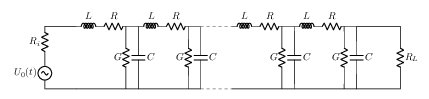

We study a transmission line with a length of 5 m, which we segment into 500 cells for the calculation. Use $C$=110 pF/m, $L$=270 nH/m, $R$=30$\mu\Omega/m$ and $G$=1 $G\Omega/m$ for your calculations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# cable parameters: length and segmentation
length = 5.0
ncell = 500
dx = length/ncell

# cable properties from http://www.farnell.com/datasheets/84294.pdf
C = 110e-12 * dx # 100 pF/m
L = 270e-9 * dx # https://www.eeweb.com/tools/coax-inductance
R = 30.0e-6 * dx # approx 10 Ohm/Mft, actually R = 10.0 / (0.3048e6) * dx
G = 1e9 * dx

## Sinusiodal signals (5 points)

Using Kirchhoff's Laws, derive the set of equations that describes the transmission line.  Solve the equations numerically for a sinusoidal input voltage with a frequency of 100 MHz, assuming an open-ended cable, a shorted cable and a cable with a termination resistor $R_L$=100$\Omega$.

What is the voltage between the wires in the middle and at the end of the cable for these three cases?

In [37]:
# SET THESE VARIABLES TO YOUR SOLUTIONS
V_open_end = 0
V_open_mid = 0
V_short_end = 0
V_short_mid = 0
V_100ohm_end = 0
V_100ohm_mid = 0

ncell = 500
num_eqns = 3 * ncell + 1

R_L = 100
R_i = 50
f = 10e5
omega = 2 * np.pi * f

def add_initial(eqns):
    # add equations for first loop
    # Voltage over input then R_i then R+L then G
    eqns[0][0] = -1
    eqns[0][1] = -1
    eqns[1][0] = 1 / ((R + R_i) + 1j * omega * L)
    eqns[1][1] = -1/G
    eqns[1][2] = -1j * omega * C
    eqns[1][3] = -1 / (R + 1j * omega * L)
    
def add_small_loop(eqns, i):
    # Includes G then C
    eqns[i][i-1] = 1
    eqns[i][i] = -1
    
def add_loop(eqns, i):
    # add equations for any loop after the first
    # Includes C then R + L then G
    eqns[i][i-1] = 1
    eqns[i][i] = -1
    eqns[i][i+1] = -1
    
def add_connector(eqns, i):
    # add equations for top corner between loops
    eqns[i][i-1] = 1 / (R + 1j * omega * L)
    eqns[i][i] = -1 / G
    eqns[i][i+1] = -1j * omega * C
    eqns[i][i+2] = -1 / (R + 1j * omega * L)
    
def add_connector_before_open_end(eqns, i):
    eqns[i][i-1] = 1 / (R + 1j * omega * L)
    eqns[i][i] = -1 / G
    eqns[i][i+1] = -1j * omega * C
    eqns[i][i+2] = 0
    
def add_open_end(eqns,i):
    eqns[i][i-1] = 1
    eqns[i][i] = -1

def add_connector_before_short_circuit(eqns, i):
    eqns[i][i-1] = 1 / (R + 1j * omega * L)
    eqns[i][i] = 0
    eqns[i][i+1] = 0
    small_resistance = 10e-9
    eqns[i][i+2] = -1 / small_resistance
    
def add_short_circuit(eqns, i):
    eqns[i][i-1] = 1
    eqns[i][i] = -1
    
def add_connector_before_termination_resistor(eqns, i, R_L):
    eqns[i][i-1] = 1 / (R + 1j * omega * L)
    eqns[i][i] = -1 / G
    eqns[i][i+1] = -1j * omega * C
    eqns[i][i+2] = -1 / R_L

def add_termination_resistor(eqns, i):
    eqns[i][i-1] = 1
    eqns[i][i] = -1


    
# Open Ended  
eqns = np.zeros((num_eqns, num_eqns), dtype=np.complex128)
add_initial(eqns)
add_small_loop(eqns, 2)

index_start = 3
i = index_start

for _ in range(ncell-2):
    add_loop(eqns, i)
    i = i + 1
    add_connector(eqns, i)
    i = i + 1
    add_small_loop(eqns, i)
    i = i + 1
add_loop(eqns, i)
i = i + 1
add_connector_before_open_end(eqns, i)
i = i + 1
add_small_loop(eqns, i)
i = i + 1
add_open_end(eqns, i)

b = np.zeros(num_eqns)
b[0] = -1 # V_0

open_soln = np.linalg.solve(eqns,b)
V_open_end = abs(open_soln[-1])
V_open_mid = abs(open_soln[ncell//2 * 3])

# Short circuit
eqns = np.zeros((num_eqns, num_eqns), dtype=np.complex128)
add_initial(eqns)
add_small_loop(eqns, 2)

index_start = 3
i = index_start
#while i < num_eqns-5:
for _ in range(ncell-2):
    add_loop(eqns, i)
    i = i + 1
    add_connector(eqns, i)
    i = i + 1
    add_small_loop(eqns, i)
    i = i + 1
add_loop(eqns, i)
i = i + 1
add_connector_before_short_circuit(eqns, i)
i = i + 1
add_small_loop(eqns, i)
i = i + 1
add_short_circuit(eqns, i)

b = np.zeros(num_eqns)
b[0] = -1 # V_0

short_soln = np.linalg.solve(eqns,b)
V_short_end = abs(short_soln[-1])
V_short_mid = abs(short_soln[ncell//2 * 3])

# Terminal Resistor
eqns = np.zeros((num_eqns, num_eqns), dtype=np.complex128)
add_initial(eqns)
add_small_loop(eqns, 2)

index_start = 3
i = index_start
#while i < num_eqns-5:
for _ in range(ncell-2):
    add_loop(eqns, i)
    i = i + 1
    add_connector(eqns, i)
    i = i + 1
    add_small_loop(eqns, i)
    i = i + 1
add_loop(eqns, i)
i = i + 1
add_connector_before_termination_resistor(eqns, i, R_L)
i = i + 1
add_small_loop(eqns, i)
i = i + 1
add_termination_resistor(eqns, i)

b = np.zeros(num_eqns)
b[0] = -1 # V_0

term_soln = np.linalg.solve(eqns,b)
V_100ohm_end = abs(term_soln[-1])
V_100ohm_mid = abs(term_soln[ncell//2 * 3])

In [33]:
assert( V_open_end > 0 )
assert( V_open_mid > 0 )

In [34]:
assert( V_short_end > 0 )
assert( V_short_mid > 0 )

In [35]:
assert( V_100ohm_end > 0 )
assert( V_100ohm_mid > 0 )

Plot the amplitude of the voltage along the cable in these three cases. Describe and explain the differences between the waveforms of the three cases.

[]

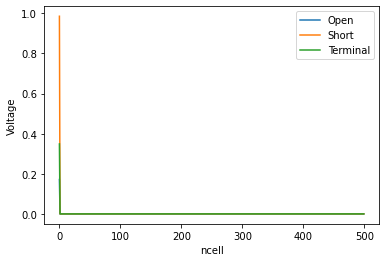

In [49]:
V = [abs(open_soln[i*3]) for i in range(0, ncell)]
plt.plot(range(len(V)), V, label="Open")

V = [abs(short_soln[i*3]) for i in range(0, ncell)]
plt.plot(range(len(V)), V, label="Short")

V = [abs(term_soln[i*3]) for i in range(0, ncell)]
plt.plot(range(len(V)), V, label="Terminal")

plt.ylabel("Voltage")
plt.xlabel("ncell")
plt.legend()
plt.plot()

YOUR ANSWER HERE

Find the value of the termination resistor $R_L$ for which the difference between the minimum and maximum amplitude of the voltage along the transmission line is smallest.

In [201]:
# SET THIS VARIABLE TO YOUR RESULT
R_L_opt = 10

def solve_for_R_L_opt():
    # Terminal Resistor
    diff = 0
    current_R_L = -1
    options = np.linspace(1, 20, 20)
    for R_L in options:
        eqns = np.zeros((num_eqns, num_eqns), dtype=np.complex)
        add_initial(eqns)
        add_small_loop(eqns, 2)

        index_start = 3
        i = index_start
        
        for _ in range(ncell-2):
            add_loop(eqns, i)
            i = i + 1
            add_connector(eqns, i)
            i = i + 1
            add_small_loop(eqns, i)
            i = i + 1
        add_loop(eqns, i)
        i = i + 1
        add_connector_before_termination_resistor(eqns, i, R_L)
        i = i + 1
        add_small_loop(eqns, i)
        i = i + 1
        add_termination_resistor(eqns, i)

        b = np.zeros(num_eqns)
        b[0] = -1 # V_0
        np.linalg.solve(eqns,b)
        
        V = [abs(term_soln[i*3]) for i in range(0, ncell)]
        diff_new = max(V) - min(V)
        if diff_new < diff:
            diff = diff_new
            current_R_L = R_L

    return current_R_L

R_L_opt = solve_for_R_L_opt()

In [200]:
assert( R_L_opt > 10 )

AssertionError: 

## Detector signal (5 points)

A detector signal is transmitted over the cable. The signal is described by an exponential: $V(t)=V_0 e^{-(t-t_0)/\tau} \Theta(t-t_0)$, where $t_0$ is the start time of the signal and
$\tau=$5ns is its decay time. Assume that the optimal termination resistor, as calculated in the previous part, is used.

Calculate and plot the Fourier transform of the detector signal.

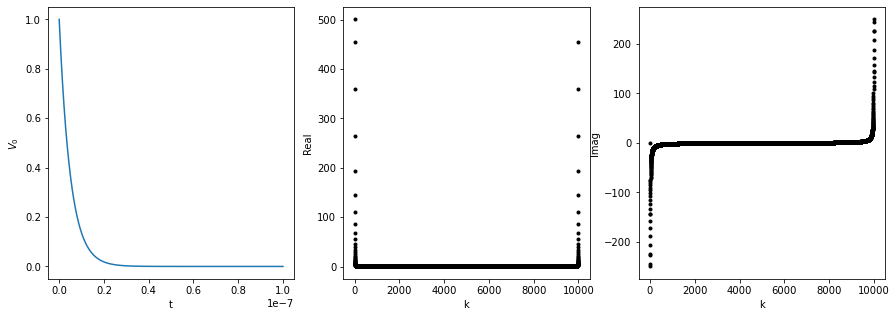

In [34]:
def V_t(t, t_0, tau, V_0):
    return V_0 * np.exp(-(t-t_0)/tau) if t-t_0 >= 0 else 0

nsamples = 10000
sample_rate = 100000000000

t = np.fromiter((n / sample_rate for n in range(nsamples)), float)
vector_V = np.vectorize(V_t)
samples = vector_V(t, 0, 5e-9, 1)
output = np.fft.fft(samples)

fig, axs = plt.subplots(1, 3, figsize=(15,5))

axs[0].plot(t, samples)
axs[0].set_xlabel("t")
axs[0].set_ylabel(r"$V_0$")

axs[1].plot(range(nsamples), output.real, ".k")
axs[1].set_xlabel(r"k")
axs[1].set_ylabel("Real")

axs[2].plot(range(nsamples), output.imag, ".k")
axs[2].set_xlabel(r"k")
axs[2].set_ylabel("Imag")
plt.show()

The detector signal is measured via the voltage drop across the termination resistor, using e.g. an oscilloscope.  Calculate and visualize the measured voltage across the termination resistor at the end of the transmission line.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

How fast does the signal travel in this transmission line?

In [ ]:
speed = 3e8 # set the speed to the determined value in m/s

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
assert( abs(speed - 1.807e+08) < 2e7)